<a href="https://colab.research.google.com/github/BrunaFerreira/Mestrado_UNIFESP/blob/main/VGG_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Bibliotecas a serem utilizadas


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import PIL
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

## 2. Leitura dos dados (imagens de glandulas salivares)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/HarmonicSS_Split_V3.csv')
df.head()

,Center,ID,Gland_Type,Machine,DeVita_Score,Omeract_Score,Sex,Age,Disease_Duration,Label_pSS,Image,Faixa_Etaria,Base
0,Udine (Italy),1,submandibular,samsung,3,3,F,72,18,1,001.jpg,Above 40,train
1,Udine (Italy),2,parotid,samsung,2,3,F,72,18,1,002.jpg,Above 40,test
2,Udine (Italy),3,parotid,samsung,3,3,F,59,1,0,003.jpg,Above 40,train
3,Udine (Italy),4,parotid,samsung,0,0,F,65,8,0,004.jpg,Above 40,train
4,Udine (Italy),5,submandibular,samsung,0,0,F,65,8,0,005.jpg,Above 40,train


In [3]:
df['Base'].value_counts()

,count
Base,
train,156
test,68


### Pre Processar imagens para usar na VGG

In [4]:
dir = '/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/dataset'

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = ImageFolder(dir + '/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

## Treinamento

### Instancia Modelo

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo VGG16 com pesos pré-treinados
model = models.vgg16(pretrained=True)

# Congela as camadas convolucionais
for param in model.features.parameters():
    param.requires_grad = False

# Substitui o classificador final para 2 classes
model.classifier[6] = nn.Linear(4096, 2)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Treino Modelo

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)


def train(model, loader, epochs=5):
    train_loss_history = []
    train_acc_history = []
    epoch_hist = []
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(loader)
        accuracy = correct / total

        train_loss_history.append(avg_loss)
        train_acc_history.append(accuracy)
        epoch_hist.append(epoch+1)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return (epoch_hist, train_loss_history,train_acc_history)

In [8]:
def graf_loss (_model,_loader, n_epocs ):
  start_time = time.time()
  epochs_, loss_train,train_acc = train(_model, _loader, epochs= n_epocs)
  end_time = time.time()
  print(f"Execution Time: {end_time - start_time} seconds")
  plt.figure(figsize=(12, 5))

  # Gráfico de Loss
  plt.plot(epochs_, loss_train, label='Loss', linewidth=3, color = 'red')
  plt.title('Loss and Accuracy per Epoch')

  # Gráfico de Acurácia
  #plt.subplot(1, 2, 2)
  plt.plot(epochs_, train_acc, label='Acuracy', linewidth=3, color = 'green')
  plt.title('Loss and Accuracy per Epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Values')
  plt.legend()
  plt.tight_layout()
  plt.show()

Epoch [1/30], Loss: 0.5039, Accuracy: 0.7885
Epoch [2/30], Loss: 0.3366, Accuracy: 0.8782
Epoch [3/30], Loss: 0.2426, Accuracy: 0.9103
Epoch [4/30], Loss: 0.2030, Accuracy: 0.9038
Epoch [5/30], Loss: 0.1452, Accuracy: 0.9231
Epoch [6/30], Loss: 0.1038, Accuracy: 0.9359
Epoch [7/30], Loss: 0.0715, Accuracy: 0.9808
Epoch [8/30], Loss: 0.0364, Accuracy: 1.0000
Epoch [9/30], Loss: 0.0280, Accuracy: 0.9936
Epoch [10/30], Loss: 0.0102, Accuracy: 1.0000
Epoch [11/30], Loss: 0.0056, Accuracy: 1.0000
Epoch [12/30], Loss: 0.0033, Accuracy: 1.0000
Epoch [13/30], Loss: 0.0019, Accuracy: 1.0000
Epoch [14/30], Loss: 0.0010, Accuracy: 1.0000
Epoch [15/30], Loss: 0.0008, Accuracy: 1.0000
Epoch [16/30], Loss: 0.0010, Accuracy: 1.0000
Epoch [17/30], Loss: 0.0007, Accuracy: 1.0000
Epoch [18/30], Loss: 0.0004, Accuracy: 1.0000
Epoch [19/30], Loss: 0.0003, Accuracy: 1.0000
Epoch [20/30], Loss: 0.0003, Accuracy: 1.0000
Epoch [21/30], Loss: 0.0002, Accuracy: 1.0000
Epoch [22/30], Loss: 0.0003, Accuracy: 1.00

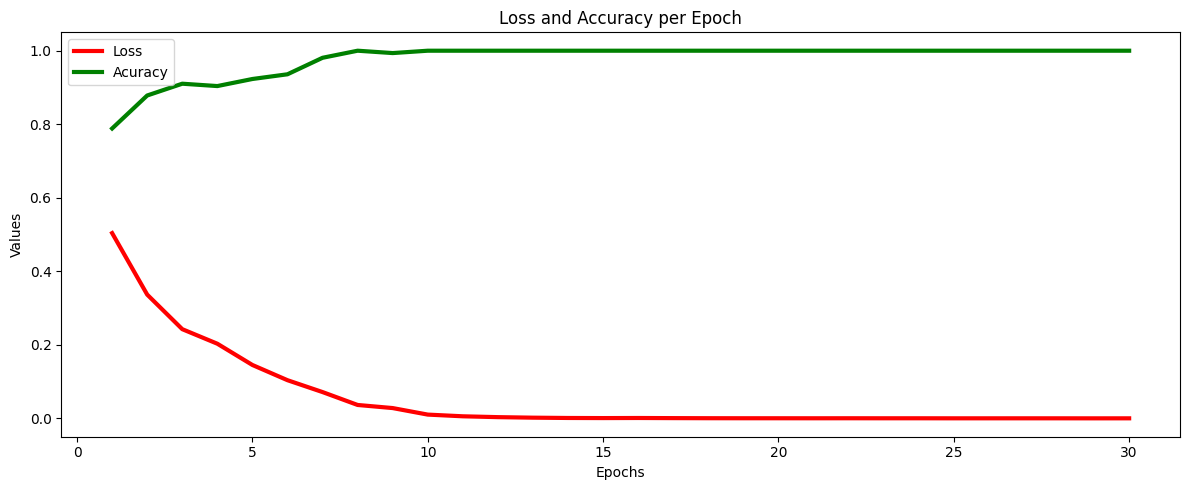

In [9]:
graf_loss (model,train_loader, 30)

### Inferencia conjunto de teste

In [10]:
from PIL import Image
import numpy as np
# Pasta com imagens
dir_test = dir + "/test"

# Classes (ordem tem que bater com a usada no treinamento)
classes = ['0', '1']

# Guardar resultados
resultados = []

with torch.no_grad():
    for nome_arquivo in os.listdir(dir_test):
        if nome_arquivo.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
            caminho_imagem = os.path.join(dir_test, nome_arquivo)

            # Abrir imagem e aplicar transform
            imagem = Image.open(caminho_imagem).convert("RGB")
            imagem_tensor = transform(imagem).unsqueeze(0).to(device)

            # Predição
            output = model(imagem_tensor)
            probs = torch.softmax(output, dim=1).cpu().numpy()[0]
            classe_predita = np.argmax(probs)
            conf = probs[classe_predita]

            resultados.append({
                'arquivo': nome_arquivo,
                'predicted_label': classes[classe_predita],
                'probabilidade': conf
            })


In [11]:
#test_data = ImageFolder(dir + '/test', transform=transform)
#test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
#graf_loss (model,test_loader, 50)

In [12]:
test_df = df[df['Base']=='test']
previsoes  = pd.DataFrame(resultados)
previsoes.columns = ['Image', 'predicted_label', 'Probability']
result = pd.merge(test_df, previsoes, on="Image", how="left")
result.head()

,Center,ID,Gland_Type,Machine,DeVita_Score,Omeract_Score,Sex,Age,Disease_Duration,Label_pSS,Image,Faixa_Etaria,Base,predicted_label,Probability
0,Udine (Italy),2,parotid,samsung,2,3,F,72,18,1,002.jpg,Above 40,test,1,1.000000
1,Udine (Italy),7,submandibular,samsung,0,0,F,55,5,1,007.jpg,Above 40,test,1,0.997023
2,Udine (Italy),13,parotid,samsung,2,2,M,66,5,1,013.jpg,Above 40,test,1,0.999261
3,Udine (Italy),14,parotid,samsung,0,0,F,74,13,1,014.jpg,Above 40,test,1,0.999585
4,Udine (Italy),16,submandibular,samsung,0,0,F,65,11,0,016.jpg,Above 40,test,1,0.999989


### Avaliação

In [13]:
def metricas (df, col_label, col_pred):

  auc = roc_auc_score(df[col_label], df[col_pred])
  f1 = f1_score(df[col_label], df[col_pred])
  acuracia = accuracy_score(df[col_label], df[col_pred])
  precision = precision_score(df[col_label], df[col_pred])
  recall = recall_score(df[col_label], df[col_pred])

  ## Matriz de confusão
  #cm = confusion_matrix(df[col_label],  df[col_pred], labels=[0,1])
  #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Without Sjogren','With Sjogren'])
  #fig, ax = plt.subplots(figsize=(5, 4))  # Tamanho da figura
  #disp.plot(ax=ax, cmap='GnBu', colorbar=True)
  ## Aumentar tamanho da fonte
  #plt.xticks(fontsize=12)
  #plt.yticks(fontsize=12)
  #plt.xlabel("Predicted", fontsize=14)
  #plt.ylabel("Actual", fontsize=14)
  #plt.title("Confusion Matrix", fontsize=16)
#
  #plt.show()

  return auc*100, f1*100, acuracia*100, precision*100, recall*100

In [ ]:
result.isna().sum()

In [ ]:
result[result['predicted_label'].isna()]

In [ ]:
result.dtypes

In [ ]:
result['predicted_label'].value_counts()

In [15]:
df_fairness  = pd.DataFrame()
result['pSS_label'] = result['Label_pSS'].astype(int)
result['predicted_label'] = result['predicted_label'].astype(int)

df_fairness['Full Dataset'] = metricas (result, "Label_pSS", "predicted_label")

## Fairness

### Idade

In [16]:
result['Age'] = result['Age'].astype(float).astype(int)
df_age_ate40 = result[result['Age']<=40]
df_fairness['Age <= 40 years'] = metricas (df_age_ate40, "Label_pSS", "predicted_label")

df_age_mais40 = result[result['Age']>40]
df_fairness['Age > 40 years'] = metricas (df_age_mais40, "Label_pSS", "predicted_label")

df_fairness

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,Full Dataset,Age <= 40 years,Age > 40 years
0,58.568738,NaN,58.111111
1,91.803279,100.0,90.384615
2,85.294118,100.0,83.050847
3,88.888889,100.0,87.037037
4,94.915254,100.0,94.000000


### Sexo

In [17]:
df_sex_F = result[result['Sex']== 'F']
df_fairness['Female'] = metricas (df_age_ate40, "Label_pSS", "predicted_label")

df_sex_M = result[result['Sex']== 'M']
df_fairness['Male'] = metricas (df_age_mais40, "Label_pSS", "predicted_label")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [19]:
df_fairness.set_index(pd.Index(['AUC', 'F1', 'Acuracy', 'Precision', 'Recall']), inplace=True)
df_fairness = df_fairness.round(2)
df_fairness

,Full Dataset,Age <= 40 years,Age > 40 years,Female,Male
AUC,58.57,NaN,58.11,NaN,58.11
F1,91.80,100.0,90.38,100.0,90.38
Acuracy,85.29,100.0,83.05,100.0,83.05
Precision,88.89,100.0,87.04,100.0,87.04
Recall,94.92,100.0,94.00,100.0,94.00
